# Charm Analysis:

This analysis is done using `Coffea` and `Awkward Arrays`. This study will focus on the event selection of W+c Events.

In [3]:
import numpy as np
import awkward as ak
import mplhep as mh
import hist as h
import matplotlib.pyplot as plt
import dask
import dask_awkward as dak
from coffea import processor
from coffea.nanoevents import NanoAODSchema, NanoEventsFactory

In [5]:
# NanoEvents: This turns NanpAOD root files into columnar object (Awkward Array)
events = NanoEventsFactory.from_root(
    {"../../datasets/nano106X_on_mini106X_2017_mc_NANOAOD_W1Jets_to_LNu_250K.root": "Events"},
    schemaclass=NanoAODSchema,    
).events()

/home/xondikoi/miniconda3/envs/Coffea/lib/python3.12/site-packages/coffea/nanoevents/mapping/uproot.py:156: UserWarning: Found duplicate branch FatJet_btagDDBvLV2 in <TTree 'Events' (1794 branches) at 0x7f3d3f187860>, taking first instance
  warnings.warn(
/home/xondikoi/miniconda3/envs/Coffea/lib/python3.12/site-packages/coffea/nanoevents/mapping/uproot.py:156: UserWarning: Found duplicate branch FatJet_btagDDCvBV2 in <TTree 'Events' (1794 branches) at 0x7f3d3f187860>, taking first instance
  warnings.warn(
/home/xondikoi/miniconda3/envs/Coffea/lib/python3.12/site-packages/coffea/nanoevents/mapping/uproot.py:156: UserWarning: Found duplicate branch FatJet_btagDDCvLV2 in <TTree 'Events' (1794 branches) at 0x7f3d3f187860>, taking first instance
  warnings.warn(
/home/xondikoi/miniconda3/envs/Coffea/lib/python3.12/site-packages/coffea/nanoevents/mapping/uproot.py:156: UserWarning: Found duplicate branch FatJet_nBHadrons in <TTree 'Events' (1794 branches) at 0x7f3d3f187860>, taking first 

In [6]:
# Kinematic Selection Cuts for Muons:  
Muon_Mt = np.sqrt(2 * events.Muon.pt * events.MET.pt * (1 - np.cos(events.Muon.phi - events.MET.phi)))
passCuts_Muon = (
    (events.Muon.pt > 35) &
    (abs(events.Muon.eta) < 2.4) &
    (events.Muon.tightId == 1) &
    (events.Muon.pfRelIso04_all < 0.15) &
    (Muon_Mt > 55)
)
Muon = events.Muon[passCuts_Muon]

In [13]:
class WcProcessor:
    def __init__(self):
        self.hists = {}
        self.hists["Muon_pT"] = self.make_hist(
            "Muon_pT", 50, 0, 200, "Muon pT [GeV]"
        )

    def make_hist(self, name, nBins, low_Lim, hi_Lim, label):
        return(
            h.Hist.new
            .Reg(nBins, low_Lim, hi_Lim, name=name, label=label)
            .Weight()
        )
    
    def process(self, events):
        RecoMuons = events.Muon
        Muon_passCuts = (
            (RecoMuons.pt > 35) &
            (abs(RecoMuons.eta) < 2.4) &
            (RecoMuons.tightId == 1) &
            (RecoMuons.pfRelIso04_all < 0.15)
        )
        SelectedMuons = RecoMuons[Muon_passCuts]

        Muon_Mask = ak.num(SelectedMuons) > 0
        Leading_Muon_pT = SelectedMuons[Muon_Mask][:,0].pt
        if hasattr(Leading_Muon_pT, "compute"):
            Leading_Muon_pT = Leading_Muon_pT.compute()
        weight = ak.ones_like(Leading_Muon_pT)
        if hasattr(weight, "compute"):
            weight = weight.compute()

        self.hists["Muon_pT"].fill(
            Muon_pT = ak.to_numpy(Leading_Muon_pT),
            weight = weight
        )
        return self.hists
    def postprocess(self, accumulator):
        return accumulator

Sum of weights per bin: [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 1.294e+03 4.960e+03 4.490e+03 4.051e+03 3.353e+03 2.596e+03
 1.744e+03 1.141e+03 8.350e+02 5.660e+02 4.070e+02 3.620e+02 2.270e+02
 1.650e+02 1.260e+02 1.050e+02 9.400e+01 7.200e+01 6.500e+01 4.500e+01
 4.500e+01 2.500e+01 2.800e+01 1.500e+01 1.900e+01 1.400e+01 2.100e+01
 1.600e+01 8.000e+00 1.400e+01 5.000e+00 5.000e+00 8.000e+00 5.000e+00
 5.000e+00 5.000e+00 4.000e+00 2.000e+00 1.000e+00 4.000e+00 2.000e+00
 3.000e+00]
Bin edges: [  0.   4.   8.  12.  16.  20.  24.  28.  32.  36.  40.  44.  48.  52.
  56.  60.  64.  68.  72.  76.  80.  84.  88.  92.  96. 100. 104. 108.
 112. 116. 120. 124. 128. 132. 136. 140. 144. 148. 152. 156. 160. 164.
 168. 172. 176. 180. 184. 188. 192. 196. 200.]


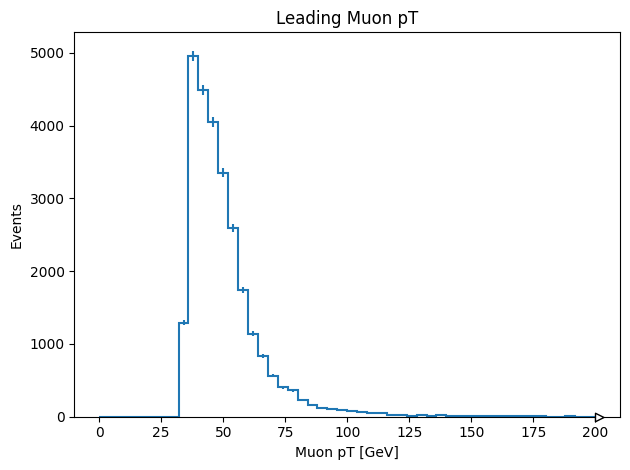

In [14]:
# Create processor instance
proc = WcProcessor()

# Run process on the NanoEvents 'events' you already built
result = proc.process(events)

# Access the histogram
h_mu = result["Muon_pT"]

# Inspect contents
print("Sum of weights per bin:", h_mu.values())
print("Bin edges:", h_mu.axes["Muon_pT"].edges)

# Plot
import mplhep as hep
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
hep.histplot(h_mu, ax=ax)
ax.set_xlabel("Muon pT [GeV]")
ax.set_ylabel("Events")
ax.set_title("Leading Muon pT")
plt.tight_layout()
plt.show()